### PREVISÃO EM UM SISTEMA DE VENDAS COMERCIAL A PARTIR DE ALGORITMOS DE INTELIGÊNCIA ARTIFICIAL

### FORECAST IN A COMMERCIAL SALES SYSTEM BASED ON ARTIFICIAL INTELLIGENCE ALGORITHMS 

### Integrantes:

### Henrique Seschin Neto RA: 202083
### Robson Agapito Correa RA: 202062

#### seschin_eletronic@hotmail.com, robsonagapito@gmail.com

### Bibliotecas

In [1]:
import numpy as np 
import pandas as pd
import sklearn 
import graphviz
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(1)
import matplotlib.pyplot as plt
from matplotlib import rcParams
from datetime import date
import datetime
import imblearn
import warnings
import matplotlib.dates as mdates
from sklearn.decomposition import PCA

warnings.simplefilter(action='ignore', category=FutureWarning)
# definindo a semente para o numpy:
np.random.seed(42)

C:\Users\sesch\AppData\Roaming\Python\Python39\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
file_base_name = "BaseTCC.txt"

In [3]:
# ALTERAR TABULAÇOES POR PIPE
def update_tab(file):
    reading_file = open(file, "r")

    new_file_content = ""
    for line in reading_file:
        stripped_line = line.strip()
        new_line = stripped_line.replace("	", "|")
        new_file_content += new_line +"\n"
    reading_file.close()

    writing_file = open(file_base_name, "w")
    writing_file.write(new_file_content)
    writing_file.close()

In [4]:
#Carregando a Base de Dados Atual
update_tab("BaseAnjos_2022_05_01.tsv")

In [5]:
# criando o dataframe do csv gerado
df = pd.read_csv(file_base_name, sep='|')

for col in df.columns:
    print(col)

codigo
nome
celular
sexo
produto01
produto02
produto03
vendeu
hora
tipo
como conheceu
melhorias
observacao
data
consultor
id_consultor
retorno
status
id_jira
id_item
orcamento
valor_orcamento


### Funcões de limpeza e tratamento da base de dados

In [6]:
# dropando as colunas
def drop_columns():
    df.drop('id_consultor',axis = 1, inplace = True)
    df.drop('nome',axis = 1, inplace = True)
    df.drop('id_jira',axis = 1, inplace = True)
    df.drop('id_item',axis = 1, inplace = True)
    df.drop('valor_orcamento',axis = 1, inplace = True)

    
# mudando os nomes das colunas
def change_name_columns():
    df.rename(columns={"Produto Desejado":"produtos", "Efetivou a venda?": "vendeu","Hora da chegada do cliente":"hora"}, inplace = True)
    df.rename(columns={"Tipo do Atendimento":"tipo", "Como conheceu a Loja?":"como_conheceu", "Como podemos melhorar o nosso fechamento? Tivemos alguma falha?":"melhorias" }, inplace = True)
    df.rename(columns={"Alguma observação final?":"observacao", "Data":"data", "Consultor de Vendas":"consultor"}, inplace = True)
    df.rename(columns={"Contato foi um retorno de atendimento anterior": "retorno"}, inplace = True)
    df.rename(columns={"Celular":"celular","Sexo":"sexo"}, inplace=True)
    
# mudando todos os dados de NaN para alguma informação específica.    
def transform_nan():
    df['celular'] = df['celular'].fillna('15000000000')
    df['tipo'] = df['tipo'].fillna('Presencial')
    df['melhorias'] = df['melhorias'].fillna('sem melhoria')
    df['observacao'] = df['observacao'].fillna('sem observacao')
    df['retorno'] = df['retorno'].fillna('Não') 
    df['como conheceu'] = df['como conheceu'].fillna('passagem frente da loja')  
    df['sexo'] = df['sexo'].fillna('casal')
    df['produto01'] = df['produto01'].fillna('vazio')
    df['produto02'] = df['produto02'].fillna('vazio')                                       
    df['produto03'] = df['produto03'].fillna('vazio')                                       
    df['vendeu'] = df['vendeu'].fillna('nao')
    df['hora'] = df['hora'].fillna('20')
    df['data'] = df['data'].fillna('01/02/2022')
    df['status'] = df['status'].fillna('sem status')
    df['orcamento'] = df['orcamento'].fillna('nao')

def update_phone(dataf):
    # retirando os traços da coluna celular:
    dataf['celular'] = dataf['celular'].str.replace('-','')
    # retirando os parenteses duplos da coluna celular:
    dataf['celular'] = dataf['celular'].str.replace('()','',regex=True)
    # retirando os parenteses simples da coluna celular:
    dataf['celular'] = dataf['celular'].str.replace('(','',regex=True)
    dataf['celular'] = dataf['celular'].str.replace(')','',regex=True)
    # retirando o + da coluna celular:
    dataf['celular'] = dataf['celular'].str.replace('+','1',regex=True)
    # retirando a sibala 'Nã' da coluna celular e substituindo por ddd 15:
    dataf['celular'] = dataf['celular'].str.replace('Nã','15',regex=True)
    dataf['celular'] = dataf['celular'].str.replace(' ','',regex=True)
    return dataf
      
def ajusta_produtos(name):
    # deixando a coluna produtos tudo em minúsculo
    df[name] = df[name].str.lower()
    # retirando o 'á' e substituindo por a:
    df[name] = df[name].str.replace('á','a')
    # retirando o "~" da coluna produtos:
    df[name] = df[name].str.replace('ã','a')
    # retirando a virgula da coluna produtos e inserido "e":
    df[name] = df[name].str.replace(', ',';')
       
# removendo e corrigindo os caracteres indesejados das colunas do dataset:
def remove_character():
    # deixando apenas os dois primeiros digitos da coluna celular:
    df['ddd'] = df['celular'].str[:2]
    # deixando a coluna sexo tudo em minúsculo
    df['sexo'] = df['sexo'].str.lower()
    # ajustando as colunas de produtos
    ajusta_produtos('produto01')
    ajusta_produtos('produto02')
    ajusta_produtos('produto03') 
    # padronização do campo vendeu:
    df['vendeu'] = df['vendeu'].str.replace('Finalizado com Venda','sim')
    df['vendeu'] = df['vendeu'].str.replace('Finalizado COM Resposta','nao')
    df['vendeu'] = df['vendeu'].str.replace('Finalizado SEM Resposta','nao')   
    # retirando o "~" da coluna vendeu:
    df['vendeu'] = df['vendeu'].str.replace('ã','a')
    # deixando a coluna vendeu tudo em minúsculo
    df['vendeu'] = df['vendeu'].str.lower()
    # passando de texto para número na coluna vendeu:
    df['vendeu'] = df['vendeu'].str.replace('nao','0.0')
    df['vendeu'] = df['vendeu'].str.replace('sim','1.0')
    # deixando a coluna tipo tudo em minúsculo
    df['tipo'] = df['tipo'].str.lower()
    # retirando a frase do campo tipo e substituindo para presencial
    df['tipo'] = df['tipo'].str.replace('cliente veio na loja e depois mantive contato por whats app','presencial')
    # deixando a coluna como conheceu tudo em minúsculo
    df['como conheceu'] = df['como conheceu'].str.lower()
    # retirando o ponto final da frase, na coluna como conheceu
    df['como conheceu'] = df['como conheceu'].str.replace('.','',regex=True)
    # juntando as classes parecidas na coluna como conheceu
    df['como conheceu'] = df['como conheceu'].str.replace('estava passando e viu a loja e entrou pra conheçer','passagem frente da loja',regex=True)
    # arrumando a frase do campo conheceu
    df['como conheceu'] = df['como conheceu'].str.replace('e já tem produtos da anjos colchoes','ja possui produtos anjos colchoes',regex=True)
    # retirando o "~" da coluna como conheceu:
    df['como conheceu'] = df['como conheceu'].str.replace('ã','a')
    # arrumando a frase da coluna conheceu
    df['como conheceu'] = df['como conheceu'].str.replace('consulta google','google')
    # removendo a hora do campo data.   
    df['data'] = df['data'].str.replace('00:00','')
    # deixando a coluna melhorias tudo em minúsculo
    df['melhorias'] = df['melhorias'].str.lower()
    # deixando a coluna observacao tudo em minúsculo
    df['observacao'] = df['observacao'].str.lower()
    # deixando a coluna consultor tudo em minúsculo
    df['consultor'] = df['consultor'].str.lower()
    # retirando o "´" da coluna consultor:
    df['consultor'] = df['consultor'].str.replace('janaína','janaina')
    # arrumando os nomes da coluna consultor:
    df['consultor'] = df['consultor'].str.replace('ari jacinto neto','ari')
    df['consultor'] = df['consultor'].str.replace('jean felipe rodrigues ribeiro','jean')
    # retirando o "~" da coluna retorno
    df['retorno'] = df['retorno'].str.replace('ã','a')
    # deixando a coluna retorno tudo em minúsculo
    df['retorno'] = df['retorno'].str.lower()
    # ajuste de hora
    df['hora'] = df['hora'].str.replace('Depois das 19h','20')
    df['hora'] = df['hora'].str.replace('Antes das 9h','8')
    #ajuste do orcamento, se existiu ou não
    df['orcamento'] = np.where(df['orcamento']!='nao', 'sim', 'nao')
    #ajustando as colunas produtos
    df['produto01'] = df['produto01'].str.replace('colchao intermediario','colchao')
    df['produto01'] = df['produto01'].str.replace('colchao macio','colchao')
    df['produto01'] = df['produto01'].str.replace('colchao firme','colchao')
    df['produto02'] = df['produto02'].str.replace('colchao intermediario','colchao')
    df['produto02'] = df['produto02'].str.replace('colchao macio','colchao')
    df['produto02'] = df['produto02'].str.replace('colchao firme','colchao')
    df['produto03'] = df['produto03'].str.replace('colchao intermediario','colchao')
    df['produto03'] = df['produto03'].str.replace('colchao macio','colchao')
    df['produto03'] = df['produto03'].str.replace('colchao firme','colchao')

In [7]:
#dropando as colunas indesejadas
drop_columns()   
#mudando os nomes
change_name_columns()
#tirando os nan
transform_nan()
#padroniza numeros de telefones
df = update_phone(df)
#removendo os caracteres indesejados
remove_character()

### Tratando as colunas produtos, transformando-as apenas em uma única coluna "Produtos"

In [8]:
#tratando as colunas produtos, tornando apenas 1 coluna, concatenando as colunas produtos
produtos_final = np.concatenate((df['produto01'], df['produto02'], df['produto03']))
f = pd.DataFrame(produtos_final, columns = ['produto'])
array_produto = f['produto'].unique()
array_valor = np.zeros(len(array_produto))
df_prod = pd.DataFrame(array_valor, array_produto)
df_prod = df_prod.transpose()
resultado = pd.concat([df,df_prod],axis=1)

array_column = list(resultado.columns)
array_value = np.zeros(len(array_column))
df_final = pd.DataFrame(array_value, array_column)
df_final = df_final.transpose()
resFor = resultado
resFor = resFor.fillna(0)

#criando um dataset apenas de produtos e unindo com o dataset final
for index,row in resFor.iterrows():
    coluna = row['produto01']
    row[coluna] = 1
    coluna = row['produto02']
    row[coluna] = 1
    coluna = row['produto03']
    row[coluna] = 1
    df_final = df_final.append(row, ignore_index=True)

#dropando as colunas de produtos01,02,03 e vazio
df_final = df_final.drop(labels=0, axis=0)
df_final = df_final.drop(labels=["produto01", "produto02","produto03","vazio"], axis=1)
df = df_final

In [9]:
#listando as colunas do dataset 
list(df.columns)

['codigo',
 'celular',
 'sexo',
 'vendeu',
 'hora',
 'tipo',
 'como conheceu',
 'melhorias',
 'observacao',
 'data',
 'consultor',
 'retorno',
 'status',
 'orcamento',
 'ddd',
 'colchao',
 'estofado',
 'box',
 'travesseiro',
 'mesa de cabeceira',
 'cama madeira',
 'cabeceira',
 'poltrona',
 'base baú',
 'tapete',
 'roupa de cama',
 'criado',
 'cabeceira ',
 'pillowtop',
 'auxiliar de molas',
 'sofa cama',
 'puff ',
 'encosto e rampa',
 'base bau',
 'base',
 'quadro',
 'recamier',
 'protetor',
 'bom baú',
 'materia prima',
 'poltrona pet',
 'box baú',
 'protetor travesseiro',
 'protetor colchao',
 'decoraçao',
 'amofadas',
 'bicama',
 'pillow']

### Convertendo e tratando a classe "data" para "dia_semana" e "ano_mes"

In [10]:
# covertendo para datetime
df['data'] = pd.to_datetime(df['data'], format="%d/%m/%Y")
# criando a coluna dia semana e chamando o dia da semana por 1 a 7
df['dia_semana'] = df['data'].apply(date.isoweekday)
#mudando o nome de cada dia da semana de 1 a 7 , pelo nome dos dias da semana
df['dia_semana'] = df['dia_semana'].replace(1,'segunda-feira')
df['dia_semana'] = df['dia_semana'].replace(2,'terça-feira')
df['dia_semana'] = df['dia_semana'].replace(3,'quarta-feira')
df['dia_semana'] = df['dia_semana'].replace(4,'quinta-feira')
df['dia_semana'] = df['dia_semana'].replace(5,'sexta-feira')
df['dia_semana'] = df['dia_semana'].replace(6,'sabado')
df['dia_semana'] = df['dia_semana'].replace(7,'domingo')
#criando a coluna mes ano, com o número do mes do ano
df['ano_mes'] = pd.DatetimeIndex(df['data']).year.astype(str) + '_'+  pd.DatetimeIndex(df['data']).month.astype(str).str.zfill(2)

In [11]:
#visualizando o dataframe após os tratamentos e limpeza na base de dados.
df.head(3)  

,codigo,celular,sexo,vendeu,hora,tipo,como conheceu,melhorias,observacao,data,...,poltrona pet,box baú,protetor travesseiro,protetor colchao,decoraçao,amofadas,bicama,pillow,dia_semana,ano_mes
1,1.0,15000000000,feminino,0.0,10,presencial,loja,cliente entrou para conhecer a loja. comentou ...,sem observacao,2021-11-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,segunda-feira,2021_11
2,2.0,13997623975,feminino,0.0,14,presencial,loja,cliente pediu o orçamento do estofado dg2009 e...,sem observacao,2021-11-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,segunda-feira,2021_11
3,3.0,15996177717,masculino,0.0,15,presencial,loja,cliente solicitou orçamento dos estofados dg 2...,sem observacao,2021-11-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,segunda-feira,2021_11


In [12]:
#analisando se existe nan no dataset
df.isna().sum()

codigo                  0
celular                 0
sexo                    0
vendeu                  0
hora                    0
tipo                    0
como conheceu           0
melhorias               0
observacao              0
data                    0
consultor               0
retorno                 0
status                  0
orcamento               0
ddd                     0
colchao                 0
estofado                0
box                     0
travesseiro             0
mesa de cabeceira       0
cama madeira            0
cabeceira               0
poltrona                0
base baú                0
tapete                  0
roupa de cama           0
criado                  0
cabeceira               0
pillowtop               0
auxiliar de molas       0
sofa cama               0
puff                    0
encosto e rampa         0
base bau                0
base                    0
quadro                  0
recamier                0
protetor                0
bom baú     

In [13]:
#785 linhas e 50 colunas no datafrane.
df.shape

(785, 50)

###  Aplicando a representação de texto NLP (Bag-of-words) nas colunas "melhorias" e "observacao" do dataset.
### Utilizando o Scikit-Learn para representar o Bag-of-Words 

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
text_melhorias = df['melhorias'] 
text_observacao = df['observacao'] 
count_melhorias = CountVectorizer()#por padrao não é binario,sem stopwors, sem quebrar espaço e faz por contagem.
count_observacao = CountVectorizer()#por padrao não é binario,sem stopwors, sem quebrar espaço e faz por contagem.
bag_of_words_melhorias = count_melhorias.fit_transform(text_melhorias)#vai construir o vocabulario e vai representar as amostras
bag_of_words_observacao = count_observacao.fit_transform(text_observacao)#vai construir o vocabulario e vai representar as amostras

### Aplicando a Técnica PCA (Principal component analysis) nas colunas do Bag-of-Words

In [15]:
#Aplicando a técnica PCA nos Bag of Words do dataset
#Para evitar Overfitting, devido ao número de colunas do dataset após o bag-of-words e por ser uma base desbalançeada
#setando o pca para reduzir para 30 colunas os bag-of-words
pca = PCA(n_components=30) 
bag_of_words_melhorias = pca.fit_transform(bag_of_words_melhorias.toarray())
bag_of_words_observacao = pca.fit_transform(bag_of_words_observacao.toarray())

In [16]:
#visualizando o shape com 30 colunas, após a aplicação da técnica PCA
bag_of_words_melhorias.shape 

(785, 30)

In [17]:
#visualizando o shape com 30 colunas, após a aplicação da técnica PCA
bag_of_words_observacao.shape

(785, 30)

### Criando o data frame do Bag-of-Words da coluna "melhorias"

In [18]:
# Criando o data frame de bow de melhorias
df_melhorias = pd.DataFrame(bag_of_words_melhorias)
df_melhorias.head(5)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.239843,-0.064448,-0.055440,-0.343532,0.620856,-1.266017,0.375677,-0.222556,-0.776803,0.919256,...,0.070888,0.051999,0.484269,0.117142,-0.051232,-0.022395,0.533378,0.150935,-0.210320,0.163504
1,1.593175,1.037809,-0.364263,0.634927,-2.220716,0.194200,1.493752,-1.000459,-0.474967,0.355335,...,-0.162933,-0.339155,0.191005,0.132011,0.691260,-0.432091,0.318709,-0.903019,-0.476583,-0.348566
2,0.770380,-0.131745,0.063813,-0.350065,-1.337646,-0.523995,0.163271,0.103556,-0.584615,-0.027289,...,0.339292,-0.797030,-0.717007,0.855654,0.233326,0.122833,0.250123,0.073038,0.262659,0.472819
3,1.817600,1.568266,1.398059,-0.547988,-0.447738,-0.615629,1.868670,-0.416891,-1.265985,-0.204430,...,0.317740,-0.432469,0.303741,0.313728,-0.290527,0.232926,0.337545,-0.416606,0.193758,-0.408968
4,1.192367,0.515092,-0.038846,-0.059142,-2.680060,-0.323013,1.187455,-0.989841,-0.042838,0.446859,...,0.082497,-0.366988,-0.665562,-0.004653,-0.071181,0.117110,-0.400129,-0.077210,-0.129843,-0.209436


### Criando o data frame do Bag-of-Words da coluna "observacao"

In [19]:
#Criando o data frame de bow de observacao
df_observacao = pd.DataFrame(bag_of_words_observacao)
df_observacao.head(5)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.243441,0.382192,0.068989,0.062324,-0.019711,-0.047032,0.017425,0.023213,-0.03117,-0.012338,...,0.005964,-0.00149,0.002871,0.001327,-0.003612,0.001249,0.000745,0.000702,0.001655,0.001475
1,-0.243441,0.382192,0.068989,0.062324,-0.019711,-0.047032,0.017425,0.023213,-0.03117,-0.012338,...,0.005964,-0.00149,0.002871,0.001327,-0.003612,0.001249,0.000745,0.000702,0.001655,0.001475
2,-0.243441,0.382192,0.068989,0.062324,-0.019711,-0.047032,0.017425,0.023213,-0.03117,-0.012338,...,0.005964,-0.00149,0.002871,0.001327,-0.003612,0.001249,0.000745,0.000702,0.001655,0.001475
3,-0.243441,0.382192,0.068989,0.062324,-0.019711,-0.047032,0.017425,0.023213,-0.03117,-0.012338,...,0.005964,-0.00149,0.002871,0.001327,-0.003612,0.001249,0.000745,0.000702,0.001655,0.001475
4,-0.243441,0.382192,0.068989,0.062324,-0.019711,-0.047032,0.017425,0.023213,-0.03117,-0.012338,...,0.005964,-0.00149,0.002871,0.001327,-0.003612,0.001249,0.000745,0.000702,0.001655,0.001475


### Concatenando o dataset [df_observacao] com o dataset [df_melhorias]

In [20]:
# concatenando os datasets de bag of words de melhorias com observacao
df_concat_bow = pd.concat([df_observacao, df_melhorias], axis=1)
df_concat_bow.head(5)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.243441,0.382192,0.068989,0.062324,-0.019711,-0.047032,0.017425,0.023213,-0.03117,-0.012338,...,0.070888,0.051999,0.484269,0.117142,-0.051232,-0.022395,0.533378,0.150935,-0.210320,0.163504
1,-0.243441,0.382192,0.068989,0.062324,-0.019711,-0.047032,0.017425,0.023213,-0.03117,-0.012338,...,-0.162933,-0.339155,0.191005,0.132011,0.691260,-0.432091,0.318709,-0.903019,-0.476583,-0.348566
2,-0.243441,0.382192,0.068989,0.062324,-0.019711,-0.047032,0.017425,0.023213,-0.03117,-0.012338,...,0.339292,-0.797030,-0.717007,0.855654,0.233326,0.122833,0.250123,0.073038,0.262659,0.472819
3,-0.243441,0.382192,0.068989,0.062324,-0.019711,-0.047032,0.017425,0.023213,-0.03117,-0.012338,...,0.317740,-0.432469,0.303741,0.313728,-0.290527,0.232926,0.337545,-0.416606,0.193758,-0.408968
4,-0.243441,0.382192,0.068989,0.062324,-0.019711,-0.047032,0.017425,0.023213,-0.03117,-0.012338,...,0.082497,-0.366988,-0.665562,-0.004653,-0.071181,0.117110,-0.400129,-0.077210,-0.129843,-0.209436


In [21]:
#visualizando o shape da concatenação entre melhorias e observação, 60 colunas.
df_concat_bow.shape

(785, 60)

### Concatenando o dataset [df_concat_bow] com o dataset [df]

In [22]:
#concatenando os datasets bag of words com o df original
result = pd.concat([df, df_concat_bow], axis=1)
result.head(3)

,codigo,celular,sexo,vendeu,hora,tipo,como conheceu,melhorias,observacao,data,...,20,21,22,23,24,25,26,27,28,29
1,1.0,15000000000,feminino,0.0,10,presencial,loja,cliente entrou para conhecer a loja. comentou ...,sem observacao,2021-11-01,...,-0.162933,-0.339155,0.191005,0.132011,0.691260,-0.432091,0.318709,-0.903019,-0.476583,-0.348566
2,2.0,13997623975,feminino,0.0,14,presencial,loja,cliente pediu o orçamento do estofado dg2009 e...,sem observacao,2021-11-01,...,0.339292,-0.797030,-0.717007,0.855654,0.233326,0.122833,0.250123,0.073038,0.262659,0.472819
3,3.0,15996177717,masculino,0.0,15,presencial,loja,cliente solicitou orçamento dos estofados dg 2...,sem observacao,2021-11-01,...,0.317740,-0.432469,0.303741,0.313728,-0.290527,0.232926,0.337545,-0.416606,0.193758,-0.408968


### Dropando as colunas "melhorias" e "obervação" , após aplicação do método bag-of-words

In [23]:
#dropando as colunas melhorias e observacao do data frame[result]
result.drop('melhorias',axis = 1, inplace = True)
result.drop('observacao',axis = 1, inplace = True)

In [24]:
#visualizando o shape do dataframe [result], com 786 linhas e 108 colunas  
result.shape

(786, 108)

In [25]:
#removendo a linha 0 do dataset e inserindo 0 nos nan restantes
result = result.drop(labels=0, axis=0)
result = result.fillna(0)
result.head(3)

,codigo,celular,sexo,vendeu,hora,tipo,como conheceu,data,consultor,retorno,...,20,21,22,23,24,25,26,27,28,29
1,1.0,15000000000,feminino,0.0,10,presencial,loja,2021-11-01,ari,nao,...,-0.162933,-0.339155,0.191005,0.132011,0.691260,-0.432091,0.318709,-0.903019,-0.476583,-0.348566
2,2.0,13997623975,feminino,0.0,14,presencial,loja,2021-11-01,ari,nao,...,0.339292,-0.797030,-0.717007,0.855654,0.233326,0.122833,0.250123,0.073038,0.262659,0.472819
3,3.0,15996177717,masculino,0.0,15,presencial,loja,2021-11-01,ari,nao,...,0.317740,-0.432469,0.303741,0.313728,-0.290527,0.232926,0.337545,-0.416606,0.193758,-0.408968


### Criando o dataset final [df_final], após aplicar os tratamentos, a técnica bag-of-words e as concatenações.

In [26]:
#criando o dataset final
df_final = result

In [27]:
#data set final, verificando se existe NaN no dataset_final.
df_final.isna().sum()

codigo     0
celular    0
sexo       0
vendeu     0
hora       0
          ..
25         0
26         0
27         0
28         0
29         0
Length: 108, dtype: int64

### Splitando os dados

In [28]:
#separando os dados para treino e test
# 70 % de treino e 30% de test:
split_size = 0.7
mask = np.random.rand(len(df_final)) < split_size
test_df = df_final[~mask]
train_df =df_final[mask]

In [29]:
train_df.shape

(564, 108)

In [30]:
test_df.shape

(221, 108)

### Separando os conjuntos de dados em Treino e Teste

In [31]:
#criando o X e o Y do dataset final
x_columns = list(df_final.columns)
#removendo as colunas de não interesse do X
x_columns = df_final.drop(columns=['vendeu','codigo','celular']).columns
#criando os X e os Y, para treino e teste
y_column = ["vendeu"]
X_train = train_df[x_columns]
y_train = train_df[y_column]
X_test = test_df[x_columns]
y_test = test_df[y_column]

### Aplicando o pré processamento Ordinal Encoder no X_train e no X_test

In [32]:
# pré processamento, transformando o dataset para valores numéricos com o Ordinal Encoder
data_encoder = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
# passando o data_encoder no X_train
X_train = data_encoder.fit_transform(X_train)
# passando o data_encoder no X_test
X_test = data_encoder.transform(X_test)

### Aplicando a técnica SMOTE no X_train e no Y_train, para ajudar no desbalanceamento do conjunto de dados

In [33]:
#Aplicando a técnica SMOTE, para balancear a base.
oversample = imblearn.over_sampling.SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

## Construindo os Métodos de Classificação,  com os dados processados pela técnica do Bag-of-Words 

### Aplicando o modelo classificador XGBoost - (Extreme Gradient Boost )

In [34]:
#carregando o modelo extreme gradient boosting (XGBoost) - Classifier
clf_XGB = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=.1,subsample=.5, use_label_encoder=True,eval_metric='mlogloss')
#treino do extreme gradient boosting (XGBoost)
xgm=clf_XGB.fit(X_train,y_train.values.ravel())
#gerando a predição do classificador extreme gradient boosting (XGBoost) - no conj. de teste
y_pred = xgm.predict(X_test)
# métricas de Validação para o XGBoost no conjunto de Teste
target_names = ['não venderá  0.0', 'venderá  1.0']
print ("Modelo XGBoost, métricas de validação para o conjunto de Teste:\n", classification_report(y_test, y_pred, target_names=target_names))

C:\Users\sesch\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo XGBoost, métricas de validação para o conjunto de Teste:
                   precision    recall  f1-score   support

não venderá  0.0       0.93      0.96      0.95       191
    venderá  1.0       0.70      0.53      0.60        30

        accuracy                           0.90       221
       macro avg       0.81      0.75      0.77       221
    weighted avg       0.90      0.90      0.90       221



### Aplicando o modelo classificador LightGBM - ( Light Gradient Boosting Machine )


In [35]:
#carregando o modelo (lightgbm) - Classifier
clf_LGBM = lgb.LGBMClassifier(num_leaves=31, max_depth=- 1, learning_rate=0.1, n_estimators=100, xgboost_dart_mode = True)
#treino do (lightgbm) - Classifier
LGBM =clf_LGBM.fit(X_train,y_train.values.ravel())
#gerando a predição do classificador (lightgbm) - Classifier - no conj. de teste
y_pred2 = LGBM.predict(X_test)
#métricas de Validação para o lightgbm Classifier no conjunto de Teste
print ("Modelo LightGBM Classifier, métricas de validação para o conjunto de Teste:\n", classification_report(y_test, y_pred2, target_names=target_names))

Modelo LightGBM Classifier, métricas de validação para o conjunto de Teste:
                   precision    recall  f1-score   support

não venderá  0.0       0.91      0.98      0.95       191
    venderá  1.0       0.80      0.40      0.53        30

        accuracy                           0.90       221
       macro avg       0.86      0.69      0.74       221
    weighted avg       0.90      0.90      0.89       221



### Aplicando o modelo Random Forest Classifier

In [36]:
#carregando o modelo
clf=RandomForestClassifier(n_estimators=200,max_depth=8, random_state=7)
#treinando o modelo
clf.fit(X_train,y_train.values.ravel())
#predizendo o modelo
y_pred4=clf.predict(X_test)
#métricas de Validação para o random forest no conjunto de Teste
print ("Modelo Random Forest, métricas de validação para o conjunto de Teste:\n", classification_report(y_test, y_pred4, target_names=target_names))

Modelo Random Forest, métricas de validação para o conjunto de Teste:
                   precision    recall  f1-score   support

não venderá  0.0       0.91      0.96      0.93       191
    venderá  1.0       0.60      0.40      0.48        30

        accuracy                           0.88       221
       macro avg       0.76      0.68      0.71       221
    weighted avg       0.87      0.88      0.87       221




### Construindo os gráficos da rede neural classificadora 

In [37]:
#funções de plot
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Épocas')
    plt.ylabel('Erro')
    plt.legend()
    plt.grid(True)


def plot_acc(history):
    plt.plot(history.history['accuracy'], label='acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)

### Normalização do X_train para ser usado na rede neural

In [38]:
#normalização
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)

### Transformando y_train e y_test para valores numéricos, para serem usados na rede neural

In [39]:
#passando de texto para int.
y_train_rede = pd.to_numeric(y_train.values.ravel())
#passando de texto para int.
y_test_rede = pd.to_numeric(y_test.values.ravel())

### Construindo a Rede Neural Artificial - Classificadora

In [40]:
model = keras.Sequential([
    normalizer,
    layers.Dense(35, activation='relu'), #camada intermediaria # relu
    layers.Dense(1, activation='sigmoid') #camada de saída sigmoid (para sair 0 ou 1) 
])

model.summary()

model.compile(optimizer='sgd',#otimizador"sgd"
              loss='binary_crossentropy',#duas classes na saida,0 ou 1 binary_crossentropy
              metrics=['accuracy'])#métrica

history = model.fit(
    X_train, y_train_rede,
    epochs=35,#épocas para treinamento
    validation_split = 0.2,#tamanho do split
    batch_size=10,#tamanho do batch no treinamento
    verbose=1#mostrar andamento no treinamento
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 165)              331       
 n)                                                              
                                                                 
 dense (Dense)               (None, 35)                5810      
                                                                 
 dense_1 (Dense)             (None, 1)                 36        
                                                                 
Total params: 6,177
Trainable params: 5,846
Non-trainable params: 331
_________________________________________________________________
Epoch 1/35
81/81 [==============================] - 1s 3ms/step - loss: 0.7173 - accuracy: 0.6032 - val_loss: 0.7053 - val_accuracy: 0.5545
Epoch 2/35
81/81 [==============================] - 0s 1ms/step - loss: 0.4772 - accuracy: 0.7898 - val_loss: 

### Gráfico do Loss do treinamento da Rede Neural

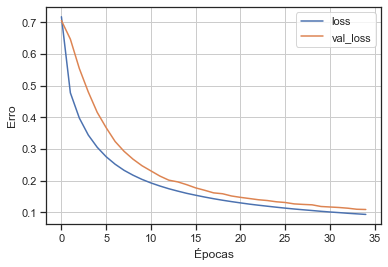

In [41]:
plot_loss(history)

### Gráfico da Acurácia do treinamento da Rede Neural

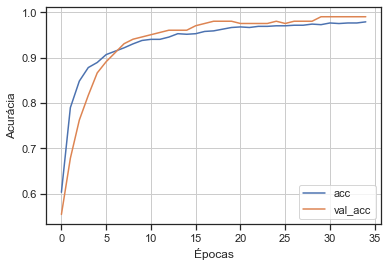

In [42]:
plot_acc(history)

### Predição e Evaluate da Rede Neural Artificial

In [43]:
y_pred5 = model.predict(X_test)
score = model.evaluate(X_test, y_test_rede,verbose=1)
print(score)

7/7 [==============================] - 0s 2ms/step - loss: 4443.6782 - accuracy: 0.8597
[4443.67822265625, 0.8597285151481628]


### Aplicando as Métricas de Validação na Rede Neural

In [44]:
#Acurácia
accuracy = accuracy_score(np.round(y_pred5), y_test_rede)
#Macro Average
macro_avg = f1_score(np.round(y_pred5), y_test_rede, average='macro')
#F1-Score
f1 = f1_score(np.round(y_pred5), y_test_rede, average= None)

# Acurácia para a rede neural
print ("A acuracia para o Modelo Rede Neural Classificadora é:\n", accuracy*100)
# Macro AVG no F1-score para a rede neural
print ("O macro AVG no F1-Score para o Modelo Rede Neural Classificadora é:\n", macro_avg*100)
# F1- Score para a rede neural
print ("Os F1-Score para Não Venderá e Venderá no Modelo Rede Neural Classificadora são:\n", f1*100)

A acuracia para o Modelo Rede Neural Classificadora é:
 85.97285067873304
O macro AVG no F1-Score para o Modelo Rede Neural Classificadora é:
 69.68181617028809
Os F1-Score para Não Venderá e Venderá no Modelo Rede Neural Classificadora são:
 [91.90600522 47.45762712]


### Resultados Finais dos Métodos de Classificação, Treinados com a Técnica de Bag-of-words

In [45]:
print ("Modelo XGBoost, métricas de validação para o conjunto de Teste:\n", classification_report(y_test, y_pred, target_names=target_names))
print ("Modelo LightGBM Classifier, métricas de validação para o conjunto de Teste:\n", classification_report(y_test, y_pred2, target_names=target_names))
print ("Modelo Random Forest, métricas de validação para o conjunto de Teste:\n", classification_report(y_test, y_pred4, target_names=target_names))
print ("A Acurácia para o Modelo de Rede Neural Classificadora é:", accuracy.round(2)*100,"%")
print ("A Macro Averaging de F1-Score para o Modelo de Rede Neural Classificadora é:", macro_avg.round(2)*100,"%")
print ("Os F1-Score para Não Venderá e Venderá, no Modelo Rede Neural Classificadora são:", f1[0].round(2)*100,"%",f1[1].round(2)*100,"%" )

Modelo XGBoost, métricas de validação para o conjunto de Teste:
                   precision    recall  f1-score   support

não venderá  0.0       0.93      0.96      0.95       191
    venderá  1.0       0.70      0.53      0.60        30

        accuracy                           0.90       221
       macro avg       0.81      0.75      0.77       221
    weighted avg       0.90      0.90      0.90       221

Modelo LightGBM Classifier, métricas de validação para o conjunto de Teste:
                   precision    recall  f1-score   support

não venderá  0.0       0.91      0.98      0.95       191
    venderá  1.0       0.80      0.40      0.53        30

        accuracy                           0.90       221
       macro avg       0.86      0.69      0.74       221
    weighted avg       0.90      0.90      0.89       221

Modelo Random Forest, métricas de validação para o conjunto de Teste:
                   precision    recall  f1-score   support

não venderá  0.0       0.9

### Calculando os Predict Proba dos modelos, usando duas amostras, para o Target "vendeu = 0  e vendeu = 1", com a técnica Bag-of-Words

In [46]:
#inserindo o predict proba para cada método método. "Pegando "duas" amostras do dataset, 
#uma positiva e uma negativa - uma amostra com a coluna vendeu = 0 e outra com coluna vendeu=1"

# >> Predict Proba no XGBOOST:

# predizendo em uma determinada posição do X_teste, onde "vendeu" = 0:
y_pred_predict0_xgboost = xgm.predict_proba([X_test[0,:]])
# probabilidade do vendeu = 0
print('Probabilidade do vendeu = 0, para o modelo XGBoost:',y_pred_predict0_xgboost)
#verificando se a coluna vendeu na posição 0 esta iagual a 0
print('Verificando se a previsão vendeu = 0 , coincide com a saída real',y_test.values[0])

# predizendo em uma determinada posição do X_teste, onde "vendeu" = 1:
y_pred_predict1_xgboost = xgm.predict_proba([X_test[60,:]])
# probabilidade do vendeu = 1
print('Probabilidade do vendeu = 1, para o modelo XGBoost:',y_pred_predict1_xgboost)
#verificando se a coluna vendeu na posição 60 esta igual a 1
print('Verificando se a previsão vendeu = 1 , coincide com a saída real',y_test.values[60])

# >> Predict Proba no lightGBM:

# predizendo em uma determinada posição do X_teste, onde "vendeu" = 0:
y_pred_predict0_lightgmb = LGBM.predict_proba([X_test[0,:]])
# probabilidade do vendeu = 0
print('\nProbabilidade do vendeu = 0, para o modelo LightGBM:',y_pred_predict0_lightgmb)
#verificando se a coluna vendeu na posição 0 esta iagual a 0
print('Verificando se a previsão vendeu = 0 , coincide com a saída real',y_test.values[0])

#predizendo em uma determinada posição do X_teste, onde "vendeu" = 1:
y_pred_predict1_lightgmb = LGBM.predict_proba([X_test[60,:]])
# probabilidade do vendeu = 1
print('Probabilidade do vendeu = 1, para o modelo LightGBM:',y_pred_predict1_lightgmb)
#verificando se a coluna vendeu na posição 60 esta igual a 1
print('Verificando se a previsão vendeu = 1 , coincide com a saída real',y_test.values[60])

# >> Predict Proba no Random Forest:

# predizendo em uma determinada posição do X_teste, onde "vendeu" = 0:
y_pred_predict0_clf = clf.predict_proba([X_test[0,:]])
# probabilidade do vendeu = 0
print('\nProbabilidade do vendeu = 0, para o modelo Random Forest:',y_pred_predict0_clf)
#verificando se a coluna vendeu na posição 0 esta iagual a 0
print('Verificando se a previsão vendeu = 0 , coincide com a saída real',y_test.values[0])

#predizendo em uma determinada posição do X_teste, onde "vendeu" = 1:
y_pred_predict1_clf = clf.predict_proba([X_test[60,:]])
# probabilidade do vendeu = 1
print('Probabilidade do vendeu = 1, para o modelo Random Forest:',y_pred_predict1_clf)
#verificando se a coluna vendeu na posição 60 esta igual a 1
print('Verificando se a previsão vendeu = 1 , coincide com a saída real',y_test.values[60])

#primeira coluna é a probabilidade de ser 0
#segunda coluna é a probabilidade de ser 1

Probabilidade do vendeu = 0, para o modelo XGBoost: [[0.9186469  0.08135314]]
Verificando se a previsão vendeu = 0 , coincide com a saída real ['0.0']
Probabilidade do vendeu = 1, para o modelo XGBoost: [[0.08120978 0.9187902 ]]
Verificando se a previsão vendeu = 1 , coincide com a saída real ['1.0']

Probabilidade do vendeu = 0, para o modelo LightGBM: [[0.99341931 0.00658069]]
Verificando se a previsão vendeu = 0 , coincide com a saída real ['0.0']
Probabilidade do vendeu = 1, para o modelo LightGBM: [[0.11225604 0.88774396]]
Verificando se a previsão vendeu = 1 , coincide com a saída real ['1.0']

Probabilidade do vendeu = 0, para o modelo Random Forest: [[0.70788674 0.29211326]]
Verificando se a previsão vendeu = 0 , coincide com a saída real ['0.0']
Probabilidade do vendeu = 1, para o modelo Random Forest: [[0.25586451 0.74413549]]
Verificando se a previsão vendeu = 1 , coincide com a saída real ['1.0']


## Construindo os Métodos de Classificação,  com os dados sem usar a técnica do Bag-of-Words 

### Separando os dados em Treino e Teste

In [47]:
#separando os dados para treino e test, sem aplicar o bag of words
# 70 % de treino e 30% de test:
split_size = 0.7
mask = np.random.rand(len(df)) < split_size
test_df_2 = df[~mask]
train_df_2 =df[mask]

#criando o X e o Y do dataset final
x_columns_2 = list(df.columns)
#removendo as colunas de não interesse do X
x_columns_2 = df.drop(columns=['vendeu','codigo','celular']).columns
#criando os X e os Y, para treino e teste
y_column_2 = ["vendeu"]
X_train_2 = train_df_2[x_columns_2]
y_train_2 = train_df_2[y_column_2]
X_test_2 = test_df_2[x_columns_2]
y_test_2 = test_df_2[y_column_2]

### Aplicando o Ordinal Encoder no X_train e X_test

In [48]:
# pré processamento, transformando o dataset para valores numéricos com o Ordinal Encoder
data_encoder_2 = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
# passando o data_encoder no X_train
X_train_2 = data_encoder_2.fit_transform(X_train_2)
# passando o data_encoder no X_test
X_test_2 = data_encoder_2.transform(X_test_2)

### Aplicando a técnica SMOTE no X_train e no y_train

In [49]:
# APLICAR O SMOTE PARA BALANCEAR A BASE, SEM O BAG-OF-WORDS
oversample = imblearn.over_sampling.SMOTE()
X_train_2, y_train_2 = oversample.fit_resample(X_train_2, y_train_2)

## Aplicando os métodos de classificação, sem utilizar a técnica do Bag-of-words.

### Aplicando o método XGBoost - (Extreme Gradient Boost ) - Sem utilizar o Bag-of-Words

In [50]:
# carregando o modelo extreme gradient boosting (XGBoost) - Classifier
clf_XGB_2 = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=.1,subsample=.5, use_label_encoder=True,eval_metric='mlogloss')
# treino do extreme gradient boosting (XGBoost)
xgm2=clf_XGB_2.fit(X_train_2,y_train_2.values.ravel())
# gerando a predição do classificador extreme gradient boosting (XGBoost) - no conj. de teste
y_pred_XGB = xgm2.predict(X_test_2)
# métricas de Validação para o XGBoost no conjunto de Teste
target_names = ['não venderá  0.0', 'venderá  1.0']
print ("Modelo XGBoost, métricas de validação para o conjunto de Teste:\n", classification_report(y_test_2, y_pred_XGB, target_names=target_names))

Modelo XGBoost, métricas de validação para o conjunto de Teste:
                   precision    recall  f1-score   support

não venderá  0.0       0.93      0.96      0.95       203
    venderá  1.0       0.65      0.52      0.58        29

        accuracy                           0.91       232
       macro avg       0.79      0.74      0.76       232
    weighted avg       0.90      0.91      0.90       232



C:\Users\sesch\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


### Aplicando o método LightGBM-(Light Gradient Boosting Machine) - Sem utilizar o Bag-of-Words

In [51]:
# caregando o modelo (lightgbm) - Classifier
clf_LGBM_2 = lgb.LGBMClassifier(num_leaves=31, max_depth=- 1, learning_rate=0.1, n_estimators=100, xgboost_dart_mode = True)
# treino do (lightgbm) - Classifier
LGBM_2 =clf_LGBM_2.fit(X_train_2,y_train_2.values.ravel())
# gerando a predição do classificador (lightgbm) - Classifier - no conj. de teste
y_pred_LGBM = LGBM_2.predict(X_test_2)
# métricas de Validação para o lightgbm Classifier no conjunto de Teste
print ("Modelo LightGBM Classifier, métricas de validação para o conjunto de Teste:\n", classification_report(y_test_2, y_pred_LGBM, target_names=target_names))

Modelo LightGBM Classifier, métricas de validação para o conjunto de Teste:
                   precision    recall  f1-score   support

não venderá  0.0       0.92      0.97      0.94       203
    venderá  1.0       0.65      0.45      0.53        29

        accuracy                           0.90       232
       macro avg       0.79      0.71      0.74       232
    weighted avg       0.89      0.90      0.89       232



### Aplicando o método Random Forest Classifier - sem utilizar o Bag-of-Words

In [52]:
# caregando o modelo Random Forest Classifier
clf_2=RandomForestClassifier(n_estimators=200,max_depth=8, random_state=7)
# treino do modelo
clf_2.fit(X_train_2,y_train_2.values.ravel())
# predict do modelo
y_pred_clf=clf_2.predict(X_test_2)
# métricas de Validação para o random forest no conjunto de Teste
print ("Modelo Random Forest, métricas de validação para o conjunto de Teste:\n", classification_report(y_test_2, y_pred_clf, target_names=target_names))

Modelo Random Forest, métricas de validação para o conjunto de Teste:
                   precision    recall  f1-score   support

não venderá  0.0       0.93      0.93      0.93       203
    venderá  1.0       0.48      0.48      0.48        29

        accuracy                           0.87       232
       macro avg       0.70      0.70      0.70       232
    weighted avg       0.87      0.87      0.87       232



### Construindo a rede neural classificadora - Sem passar os dados pelo Bag-of-Words

### Aplicando a normalização no X_train, para ser usado na rede neural

In [53]:
#normalização
normalizer_2 = preprocessing.Normalization()
normalizer_2.adapt(X_train_2)

### Transformando y_train e y_test para valores numéricos, para serem usados na rede neural

In [54]:
#passando de texto para int.
y_train_rede_2 = pd.to_numeric(y_train_2.values.ravel())
#passando de texto para int.
y_test_rede_2 = pd.to_numeric(y_test_2.values.ravel())

### Construindo a Rede Neural Artificial - Classificadora

In [55]:
model_2 = keras.Sequential([
    normalizer_2,
    layers.Dense(35, activation='relu'), #camada intermediaria # relu
    layers.Dense(1, activation='sigmoid') #camada de saída entre 0 e 1 
])

model_2.summary()

model_2.compile(optimizer='sgd',  # optimizer "sgd"
              loss='binary_crossentropy', # duas classes na saida, 0 ou 1 binary_crossentropy
              metrics=['accuracy'])

history_2 = model_2.fit(
    X_train_2, y_train_rede_2,
    epochs=35,    
    validation_split = 0.2,
    batch_size=10, 
    verbose=1
    )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 47)               95        
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 35)                1680      
                                                                 
 dense_3 (Dense)             (None, 1)                 36        
                                                                 
Total params: 1,811
Trainable params: 1,716
Non-trainable params: 95
_________________________________________________________________
Epoch 1/35
79/79 [==============================] - 1s 4ms/step - loss: 0.6334 - accuracy: 0.6204 - val_loss: 0.7810 - val_accuracy: 0.4416
Epoch 2/35
79/79 [==============================] - 0s 1ms/step - loss: 0.5340 - accuracy: 0.6892 - val_loss:

### Gráfico do Loss da Rede Neural Artificial

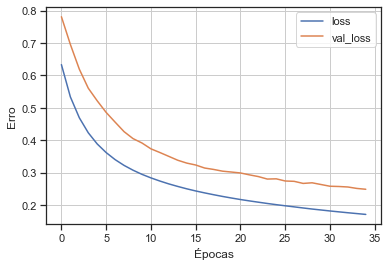

In [56]:
plot_loss(history_2)

### Gráfico da Acurácia da Rede Neural Artificial

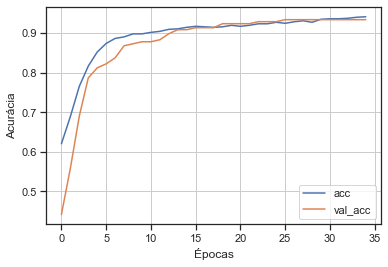

In [57]:
plot_acc(history_2)

### Predição e Evaluate da Rede Neural Artificial

In [58]:
y_pred_rede = model_2.predict(X_test_2)
score_2 = model_2.evaluate(X_test_2, y_test_rede_2,verbose=1)
print(score)

8/8 [==============================] - 0s 3ms/step - loss: 0.2903 - accuracy: 0.8879
[4443.67822265625, 0.8597285151481628]


### Aplicando as Métricas de Validação na Rede Neural

In [59]:
#Acurácia
accuracy_2 = accuracy_score(np.round(y_pred_rede), y_test_rede_2)
#Macro Averaging
macro_avg_2 = f1_score(np.round(y_pred_rede), y_test_rede_2, average='macro')
#F1-Score
f1_2 = f1_score(np.round(y_pred_rede), y_test_rede_2, average= None)

# Acurácia para a rede neural
print ("A acuracia para o Modelo Rede Neural Classificadora é:\n", accuracy_2*100)
# Macro AVG no F1-score para a rede neural
print ("O macro AVG no F1-Score para o Modelo Rede Neural Classificadora é:\n", macro_avg_2*100)
# F1- Score para a rede neural
print ("Os F1-Score para Não Venderá e Venderá no Modelo Rede Neural Classificadora são:\n", f1_2*100)

A acuracia para o Modelo Rede Neural Classificadora é:
 88.79310344827587
O macro AVG no F1-Score para o Modelo Rede Neural Classificadora é:
 76.4375
Os F1-Score para Não Venderá e Venderá no Modelo Rede Neural Classificadora são:
 [93.5   59.375]


### Resultados finais dos métodos de classificação, sem passar os dados pela técnica do Bag-of-Words


In [60]:
print ("Modelo XGBoost, métricas de validação para o conjunto de Teste:\n", classification_report(y_test_2, y_pred_XGB, target_names=target_names))
print ("Modelo LightGBM Classifier, métricas de validação para o conjunto de Teste:\n", classification_report(y_test_2, y_pred_LGBM, target_names=target_names))
print ("Modelo Random Forest, métricas de validação para o conjunto de Teste:\n", classification_report(y_test_2, y_pred_clf, target_names=target_names))
print ("A Acurácia para o Modelo de Rede Neural Classificadora é:", accuracy_2.round(2)*100,"%")
print ("A Macro Average de F1-Score para o Modelo de Rede Neural Classificadora é:", macro_avg_2.round(2)*100,"%")
print ("Os F1-Score para Não Venderá e Venderá, no Modelo Rede Neural Classificadora são:", f1_2[0].round(2)*100,"%",f1_2[1].round(2)*100,"%" )

Modelo XGBoost, métricas de validação para o conjunto de Teste:
                   precision    recall  f1-score   support

não venderá  0.0       0.93      0.96      0.95       203
    venderá  1.0       0.65      0.52      0.58        29

        accuracy                           0.91       232
       macro avg       0.79      0.74      0.76       232
    weighted avg       0.90      0.91      0.90       232

Modelo LightGBM Classifier, métricas de validação para o conjunto de Teste:
                   precision    recall  f1-score   support

não venderá  0.0       0.92      0.97      0.94       203
    venderá  1.0       0.65      0.45      0.53        29

        accuracy                           0.90       232
       macro avg       0.79      0.71      0.74       232
    weighted avg       0.89      0.90      0.89       232

Modelo Random Forest, métricas de validação para o conjunto de Teste:
                   precision    recall  f1-score   support

não venderá  0.0       0.9

### Calculando os Predict Proba dos modelos, usando duas amostras, para o Target "vendeu = 0  e vendeu = 1" - Sem aplicar a técnica Bag-of-Words

In [61]:
#inserindo o predict proba para cada método método. "Pegando "duas" amostras do dataset, 
#uma positiva e uma negativa - uma amostra com a coluna vendeu = 0 e outra com coluna vendeu=1"

# >> Predict Proba no XGBOOST:

# predizendo em uma determinada posição do X_teste, onde "vendeu" = 0:
y_pred_predict0_xgboost = xgm2.predict_proba([X_test_2[0,:]])
# probabilidade do vendeu = 0
print('Probabilidade do vendeu = 0, para o modelo XGBoost:',y_pred_predict0_xgboost)
#verificando se a coluna vendeu na posição 0 esta iagual a 0
print('Verificando se a previsão vendeu = 0 , coincide com a saída real',y_test_2.values[0])

# predizendo em uma determinada posição do X_teste, onde "vendeu" = 1:
y_pred_predict1_xgboost = xgm2.predict_proba([X_test_2[60,:]])
# probabilidade do vendeu = 1
print('Probabilidade do vendeu = 1, para o modelo XGBoost:',y_pred_predict1_xgboost)
#verificando se a coluna vendeu na posição 60 esta igual a 1
print('Verificando se a previsão vendeu = 1 , coincide com a saída real',y_test_2.values[60])

# >> Predict Proba no lightGBM:

# predizendo em uma determinada posição do X_teste, onde "vendeu" = 0:
y_pred_predict0_lightgmb = LGBM_2.predict_proba([X_test_2[0,:]])
# probabilidade do vendeu = 0
print('\nProbabilidade do vendeu = 0, para o modelo LightGBM:',y_pred_predict0_lightgmb)
#verificando se a coluna vendeu na posição 0 esta iagual a 0
print('Verificando se a previsão vendeu = 0 , coincide com a saída real',y_test_2.values[0])

#predizendo em uma determinada posição do X_teste, onde "vendeu" = 1:
y_pred_predict1_lightgmb = LGBM_2.predict_proba([X_test_2[60,:]])
# probabilidade do vendeu = 1
print('Probabilidade do vendeu = 1, para o modelo LightGBM:',y_pred_predict1_lightgmb)
#verificando se a coluna vendeu na posição 60 esta igual a 1
print('Verificando se a previsão vendeu = 1 , coincide com a saída real',y_test_2.values[60])

# >> Predict Proba no Random Forest:

# predizendo em uma determinada posição do X_teste, onde "vendeu" = 0:
y_pred_predict0_clf = clf_2.predict_proba([X_test_2[0,:]])
# probabilidade do vendeu = 0
print('\nProbabilidade do vendeu = 0, para o modelo Random Forest:',y_pred_predict0_clf)
#verificando se a coluna vendeu na posição 0 esta iagual a 0
print('Verificando se a previsão vendeu = 0 , coincide com a saída real',y_test_2.values[0])

#predizendo em uma determinada posição do X_teste, onde "vendeu" = 1:
y_pred_predict1_clf = clf_2.predict_proba([X_test_2[60,:]])
# probabilidade do vendeu = 1
print('Probabilidade do vendeu = 1, para o modelo Random Forest:',y_pred_predict1_clf)
#verificando se a coluna vendeu na posição 60 esta igual a 1
print('Verificando se a previsão vendeu = 1 , coincide com a saída real',y_test_2.values[60])

#primeira coluna é a probabilidade de ser 0
#segunda coluna é a probabilidade de ser 1

Probabilidade do vendeu = 0, para o modelo XGBoost: [[0.99645287 0.00354714]]
Verificando se a previsão vendeu = 0 , coincide com a saída real ['0.0']
Probabilidade do vendeu = 1, para o modelo XGBoost: [[0.6490389  0.35096112]]
Verificando se a previsão vendeu = 1 , coincide com a saída real ['1.0']

Probabilidade do vendeu = 0, para o modelo LightGBM: [[9.99961477e-01 3.85228977e-05]]
Verificando se a previsão vendeu = 0 , coincide com a saída real ['0.0']
Probabilidade do vendeu = 1, para o modelo LightGBM: [[0.96427239 0.03572761]]
Verificando se a previsão vendeu = 1 , coincide com a saída real ['1.0']

Probabilidade do vendeu = 0, para o modelo Random Forest: [[0.93608178 0.06391822]]
Verificando se a previsão vendeu = 0 , coincide com a saída real ['0.0']
Probabilidade do vendeu = 1, para o modelo Random Forest: [[0.52910377 0.47089623]]
Verificando se a previsão vendeu = 1 , coincide com a saída real ['1.0']


## Gráficos

In [62]:
#parâmetros dos gráficos
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
rcParams['figure.figsize'] = 11,5

In [63]:
#Função para ajustar as legendas do gráfico
def ajusta_df_grafico(df):
    dataAux = df.copy(deep=True)
    filter = (dataAux["data"] >= data_ini) & (dataAux["data"] <= data_fin) 
    dataAux['vendeu'] = dataAux['vendeu'].str.replace('1.0','Sim')
    dataAux['vendeu'] = dataAux['vendeu'].str.replace('0.0','Não')
    dataAux.rename(columns={"vendeu":"Venda Realizada"}, inplace=True)
    dataAux = dataAux.where(filter)
    return dataAux

### Quantidade de Fechamentos/Clientes por Mês

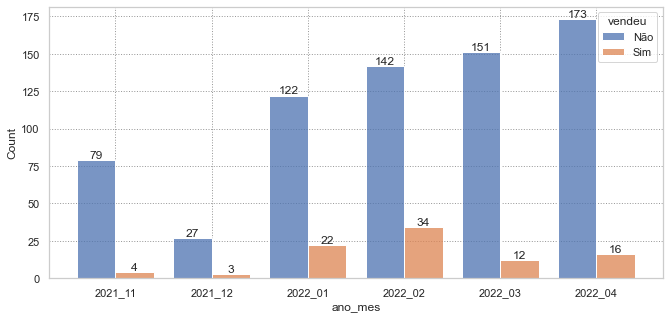

In [64]:
dataAux = df.copy(deep=True)
dataAux = dataAux.sort_values(by='ano_mes', ascending=True)
dataAux['vendeu'] = dataAux['vendeu'].str.replace('1.0','Sim')
dataAux['vendeu'] = dataAux['vendeu'].str.replace('0.0','Não')

y = sns.histplot(data=dataAux, x="ano_mes", hue="vendeu", multiple="dodge", shrink=.8)
y.bar_label(y.containers[1])
y.bar_label(y.containers[0])
plt.show()

### Primeiro contato dos leads: Online x Presencial

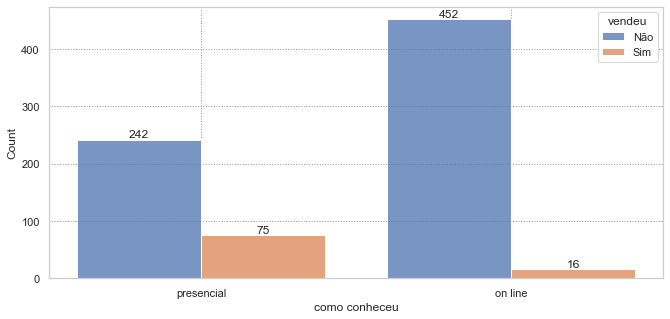

In [65]:
dataAux = df.copy(deep=True)
dataAux['como conheceu'] = dataAux['como conheceu'].str.replace('passagem frente da loja', 'presencial')
dataAux['como conheceu'] = dataAux['como conheceu'].str.replace('google', 'on line')
dataAux['como conheceu'] = dataAux['como conheceu'].str.replace('landing page', 'on line')
dataAux['como conheceu'] = dataAux['como conheceu'].str.replace('instagram', 'on line')
dataAux['como conheceu'] = dataAux['como conheceu'].str.replace('facebook', 'on line')
dataAux['como conheceu'] = dataAux['como conheceu'].str.replace('whatsapp', 'on line')
dataAux['como conheceu'] = dataAux['como conheceu'].str.replace('telefone', 'on line')
dataAux['como conheceu'] = dataAux['como conheceu'].str.replace('loja', 'presencial')
dataAux['vendeu'] = dataAux['vendeu'].str.replace('1.0','Sim')
dataAux['vendeu'] = dataAux['vendeu'].str.replace('0.0','Não')

y = sns.histplot(data=dataAux, x="como conheceu", hue="vendeu",  multiple="dodge", shrink=.8)
y.bar_label(y.containers[1])
y.bar_label(y.containers[0])
plt.show()

### Definindo um período para as consultas

In [66]:
data_ini = "2022-03-20"
data_fin = "2022-04-19"

### Quantidade de Fechamentos/Clientes por Dia da Semana

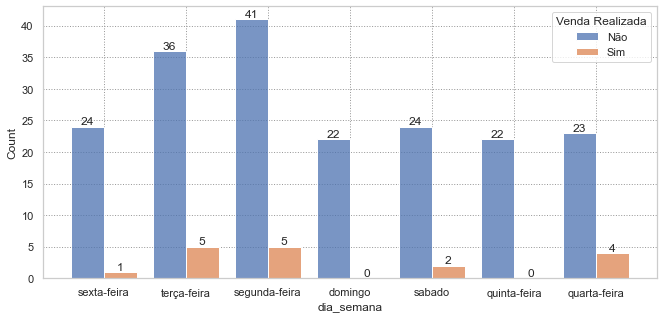

In [67]:
dataAux = ajusta_df_grafico(df)
y = sns.histplot(data=dataAux, x="dia_semana", hue="Venda Realizada", multiple="dodge",shrink=.8)
y.bar_label(y.containers[1])
y.bar_label(y.containers[0])
plt.show()

### Quantidade de Fechamentos/Clientes por Gênero

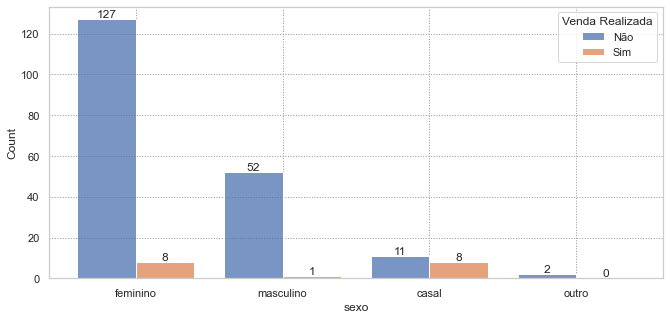

In [68]:
dataAux = ajusta_df_grafico(df)
y = sns.histplot(data=dataAux, x="sexo", hue="Venda Realizada",multiple="dodge", shrink=.8)
y.bar_label(y.containers[1])
y.bar_label(y.containers[0])
plt.show()

### Quantidade de Clientes por Tipo de atendimento

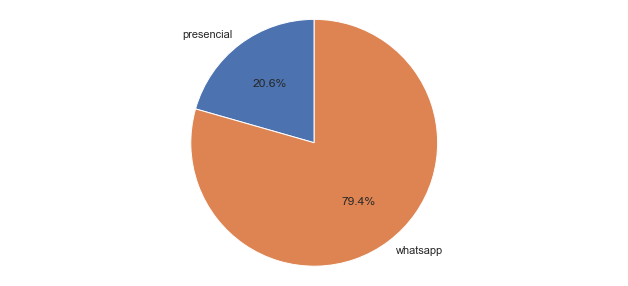

In [69]:
#Configurando o Gráfico de Setores
dataAux = ajusta_df_grafico(df)
df_graf = dataAux.groupby(['tipo']).count()
df_graf = df_graf.get(["codigo"])

# Gráfico de setores, onde as fatias serão ordenadas e plotadas
labels = df_graf.index.values
sizes = df_graf.get("codigo").values
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)  # gráfico de setores
ax1.axis('equal')   # Proporção de aspecto igual garante que a torta seja desenhada como um círculo.
plt.show()

### Quantidade de Clientes por Primeiro Contato

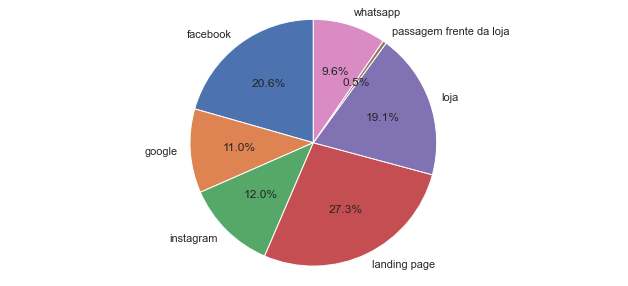

In [70]:
#Configurando o gráfico de Setores
dataAux = ajusta_df_grafico(df)
df_graf = dataAux.groupby(['como conheceu']).count()
df_graf = df_graf.get(["codigo"])

# Gráfico de setores, onde as fatias serão ordenadas e plotadas
labels = df_graf.index.values
sizes = df_graf.get("codigo").values
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)  # gráfico de setores
ax1.axis('equal')   # Proporção de aspecto igual garante que a torta seja desenhada como um círculo.
plt.show()

### Clientes por dia

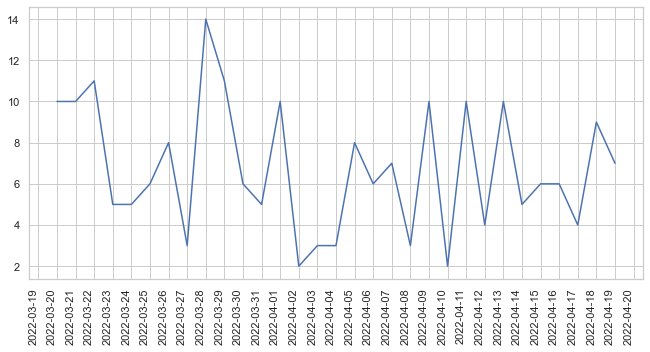

In [71]:
#Configurando o gráfico de Linha
dataAux = ajusta_df_grafico(df)
df_graf = dataAux.groupby(['data']).count()
df_graf = df_graf.get(["codigo"])
df_graf

labels = df_graf.index.values
sizes = df_graf.get("codigo").values
sns.set_style("whitegrid", {"grid.color": ".8"})

ax = sns.lineplot(labels,sizes)
ax.bar_label(y.containers[1])

plt.xticks(rotation=90,horizontalalignment='right',fontweight='light')
locator = mdates.DayLocator(interval=1)

ax.xaxis.set_major_locator(locator)
plt.show()

### Fechamento Presencial e Online

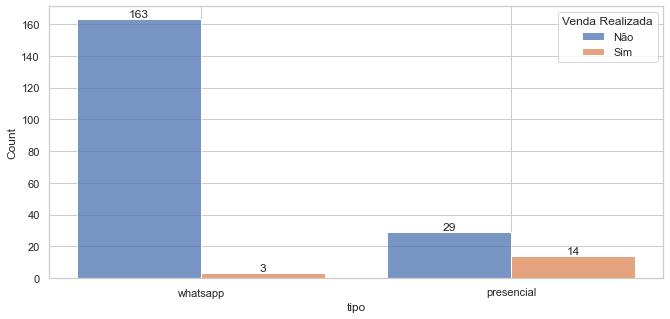

In [72]:
dataAux = ajusta_df_grafico(df)
y = sns.histplot(data=dataAux, x="tipo", hue="Venda Realizada",multiple="dodge", shrink=.8)
y.bar_label(y.containers[1])
y.bar_label(y.containers[0])
plt.show()

### Orçamentos sem Venda e com Venda

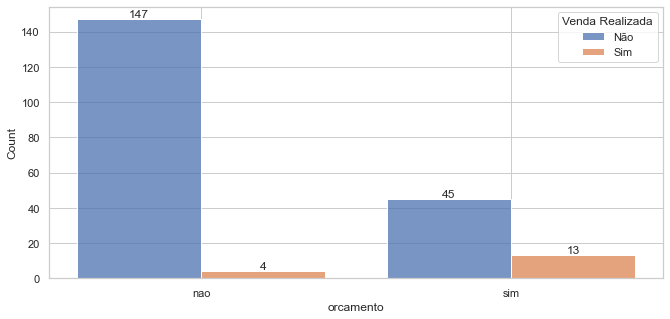

In [73]:
dataAux = ajusta_df_grafico(df)
y = sns.histplot(data=dataAux, x="orcamento", hue="Venda Realizada",multiple="dodge", shrink=.8)
y.bar_label(y.containers[1])
y.bar_label(y.containers[0])
plt.show()